<p style = "color : #28AFEA; font-size : 40px; font-family : 'Comic Sans MS'; text-align : center;"><strong>Fish Analysis , prediction and statistic</strong></p>

In [ ]:
! pip install -q kaggle

# **0. Importing Libraries**

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>First, we need to transfer data from the input folder to the working folder, because in the first case we will not be able to change the input data, but can only read. The first line is responsible for data movement. This line usually takes a long time to execute, so don't be alarmed</strong></p>

In [ ]:
!cp -r ../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset /kaggle/working
! pip install timm
! pip install -q imutils

In [ ]:
CFG = {
    'fold_num': 3,
    'seed': 125,
    'img_size': 224, 
    'train_bs': 128,
    'valid_bs': 128,
    'weight_decay':1e-6,
    'model_arch': 'gluon_resnet50_v1b', 
    'epochs': 10,
    'lr': 0.0001,
    'num_workers': 4,
    'accum_iter': 1,
    'fold_num': 3,
    'accelerator': 'GPU', 
    'num_classes': 9,
    'grad_clip': 0.001
}

In [ ]:
if CFG['accelerator']=='TPU':
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
    import torch
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.debug.metrics as met
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.utils.utils as xu
    import os
    import cv2
    import numpy as np
    import math 
    import matplotlib.pyplot as plt
    os.environ["XLA_USE_BF16"] = "1"
    os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"
    device = xm.xla_device()
    
if CFG['accelerator']=='GPU':
    import torch
    device = torch.device('cuda:0')
    print(torch.cuda.is_available())

In [ ]:
img1 = cv2.imread("/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00004.png")
img2 = cv2.imread("/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00010.png")
print(img1.shape)
print(img2.shape)

In [ ]:
from glob import glob
import joblib
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import io

from datetime import datetime
#import torchvision
#from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
#from torchvision.utils import make_grid 
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
import os
from os.path import join
from os import listdir, rmdir
from shutil import move
import random
from operator import itemgetter
import copy
import time
import timm

from mpl_toolkits.axes_grid1 import ImageGrid
import pydicom
from scipy.ndimage.interpolation import zoom
from scipy.cluster.vq import kmeans,whiten
from scipy.stats import zscore
from operator import itemgetter

import optuna
from optuna.trial import TrialState
import shutil

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import imutils
import gc

import warnings
warnings.filterwarnings("ignore")

# **1. Exploratory Data Analysis (EDA)**

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Outlier processing is an important part of preparing data for feeding into a neural network. Outliers can be a serious problem because the neural network does not know what is outlier and what is not, and learns from all the data. Learning from outliers is not a good idea for generalizing the sample, because outliers have anamous properties and those regularities that a neural network learns from outliers simply will not apply to the data as a whole</strong></p>

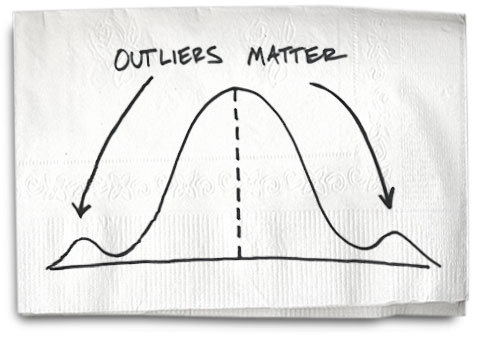

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Assign the path to the working folder to the variable</strong></p>

In [ ]:
input_path = './Fish_Dataset'

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>To carry out experiments and so that your results do not differ from mine, we will make our code more deterministic</strong></p>

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['seed'])

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>The fact is that the class folder contains two more folders. The first folder is for classification and the second for segmentation. So in this project we are engaged in classification, then we only need it, therefore I decided to delete the folder with the data for segmentation</strong></p>

In [ ]:
for i in os.listdir(input_path):
    if os.path.isdir(input_path+'/'+i)==False:
        os.remove(input_path+'/'+i)
    else:
        for x in os.listdir(input_path+'/'+i): 
            if x.split()[-1]=='GT':
                shutil.rmtree(input_path+'/'+i+'/'+x)

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>After we deleted the folder, it would be great to move all photos from the folder with the classification data to the original class folder</strong></p>

In [ ]:
for folders in os.listdir(input_path):
    root = input_path+'/'+folders+'/'
    for filename in listdir(join(root, folders)):
        move(join(root, folders, filename), join(root, filename))
    rmdir(join(root, folders))

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>For convenience, I transferred the image data to the pandas table</strong></p>

In [ ]:
data = {'image_id': [], 'labels': []}

for folders in os.listdir(input_path):
    for files in os.listdir(input_path+'/'+folders):
        data['image_id'].append (input_path+'/'+folders+'/'+files)
        data['labels'].append(folders)
        
all_data = pd.DataFrame.from_dict(data)
all_data

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Since the creator of the dataset did not provide test data, we will have to do it ourselves</strong></p>

In [ ]:
train, test = train_test_split(all_data, test_size=0.3, random_state=CFG['seed'], shuffle=True)

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>As expected, the distribution of classes is the same, because the author of the dataset wrote about this</strong></p>

In [ ]:
fig = go.Figure(
    data=[ go.Bar(x=train['labels'].value_counts().index, 
            y=train['labels'].value_counts().values,
            text=train['labels'].value_counts().values,
            textposition='auto',name='Count',
           marker_color='indianred')],
    layout_title_text="Class distribution"
)
fig.show()

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Since we will process outliers, or rather find and delete them, we need criteria by which we will determine these outliers</strong></p>

In [ ]:
for idx in tqdm(train.index):
    img_name = train.loc[idx,'image_id']
    #reading the image and converting BGR color space to RGB
    img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
    
    #normalize the image in the range [0,1]
    norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    width,height,depth = img.shape
    
    #adding new column to the tabel with width height and aspect ratio for every image
    train.loc[idx,'Width'] = width
    train.loc[idx,'Height'] = height
    train.loc[idx,'Aspect Ratio'] = width/height
    
    #calculate mean and standart deviation for each image
    train.loc[idx,'Mean'] = img.mean()
    train.loc[idx,'SD'] = img.std()
    
    #calculate mean and standart deviation for each normalized image
    train.loc[idx,'Normalized_Mean'] = norm_image.mean()
    train.loc[idx,'Normalized_SD'] = norm_image.std()
train

# **1.1 Outlier Detection using Mean and Standard Deviation**

In [ ]:
fig =  make_subplots(rows=2,cols=1,subplot_titles=['Original Image', 'Normalized Image'])
colors = ['rgb({}, {}, {})'.format(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for iter in range(len(train['labels'].unique()))]
for idx,class_name in enumerate(train['labels'].unique()):
    #scatter plot between mean and variance of the images for every disease
    fig.add_trace(go.Scatter(x=train[train['labels'] == class_name]['Mean'],
                             y=train[train['labels'] == class_name]['SD'],
                            mode = 'markers',name=class_name, marker_color=colors[idx]),1,1)
    
    #scatter plot between mean and variance of the normalized images for every disease
    fig.add_trace(go.Scatter(x=train[train['labels'] == class_name]['Normalized_Mean'],
                             y=train[train['labels'] == class_name]['Normalized_SD'],
                            mode = 'markers',name=class_name, marker_color=colors[idx], showlegend=False),2,1)
#x-axis and y axis title
fig.update_xaxes(title_text="Mean", row=1, col=1)
fig.update_yaxes(title_text="Standard Deviation", row=1, col=1)

fig.update_xaxes(title_text="Mean", row=2, col=1)
fig.update_yaxes(title_text="Standard Deviation", row=2, col=1)
fig.show()

In [ ]:
fig = make_subplots(rows=2,cols=2,
                    subplot_titles=['Mean','Standard Deviation','Normalized Mean','Normalized Standard Deviation'],
                    shared_xaxes=True)
colors = ['rgb({}, {}, {})'.format(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for iter in range(len(train['labels'].unique()))]
for idx,class_name in enumerate(train['labels'].unique()):
    fig.add_trace(go.Box(y=train[train['labels'] == class_name]['Mean'],
                        name=class_name,showlegend=False,
                        marker_color=colors[idx]),1,1)
    fig.add_trace(go.Box(y=train[train['labels'] == class_name]['Normalized_Mean'],
                        name=class_name,showlegend=False,
                        marker_color=colors[idx]),2,1)
    fig.add_trace(go.Box(y=train[train['labels'] == class_name]['SD'],
                        name=class_name,showlegend=False,
                        marker_color=colors[idx]),1,2)
    fig.add_trace(go.Box(y=train[train['labels'] == class_name]['Normalized_SD'],
                        name=class_name,showlegend=False,
                        marker_color=colors[idx]),2,2)
fig.update_layout(title='Outlier Detection - Box Plot')
fig.show()

<p style = "color : #28AFEA; font-size : 30px; font-family : 'Comic Sans MS'; text-align : center;"><strong>Boxplot Anatomy</strong></p>

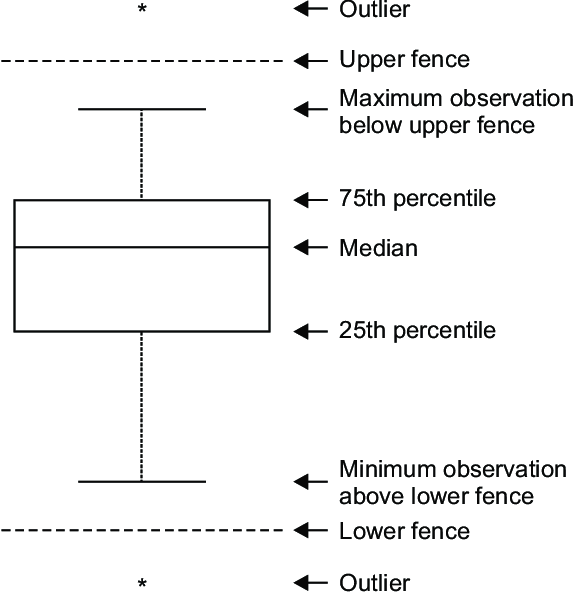

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Based on Boxplot, we will calculate the first outliers. As you already saw from the explanation above, anything that is not between upper_fence and lower_fence will be considered an outlier</strong></p>

In [ ]:
def calculate_fences(array):
    upper_fence = array.describe()['75%']+1.5*(array.describe()['75%']-array.describe()['25%'])
    lower_fence = array.describe()['25%']-1.5*(array.describe()['75%']-array.describe()['25%'])
    return lower_fence, upper_fence

In [ ]:
outliers = set()

for species in train['labels'].unique():
    images  = train[train['labels'] ==  species]
    
    data_for_fences_mean = train[train['labels']==species].loc[:, 'Normalized_Mean']
    data_for_fences_sd = train[train['labels']==species].loc[:, 'Normalized_SD']
    
    outliers_mean = images[images['Normalized_Mean'].between(calculate_fences(data_for_fences_mean)[0],calculate_fences(data_for_fences_mean)[1],inclusive=True)]
    outliers_mean = images[~images['image_id'].isin(outliers_mean['image_id'])]
    
    outliers_st = images[images['Normalized_SD'].between(calculate_fences(data_for_fences_sd)[0],calculate_fences(data_for_fences_sd)[1],inclusive=True)]
    outliers_st = images[~images['image_id'].isin(outliers_st['image_id'])]
    
    delete_mean = set(outliers_mean['image_id'].astype(str).values)
    delete_st= outliers_st['image_id'].astype(str).values
    outliers = outliers.union(delete_mean)
    outliers = outliers.union(delete_st)
    
print('Number of Outliers:', len(outliers))

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Let's see what the outlier looks like</strong></p>

In [ ]:
imgs = list(outliers)

gridimg = []        
for idx,img_name in enumerate(np.random.choice(imgs,25,replace=False)):
    np_image = mpimg.imread(img_name)
    gridimg.append(np_image)

fig = plt.figure(figsize=(25, 25))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(5, 5),  
                 axes_pad=0.1,  
                 label_mode="1")

for ax, im in zip(grid, gridimg):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')

plt.show()

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>We looked at the outliers, now we can delete them from the folder and from the table</strong></p>

In [ ]:
for images in outliers:
    os.remove(images)
    train = train.drop(train[train['image_id']==images].index)

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>You need to check if the number of rows in the table has changed</strong></p>

In [ ]:
train

# **1.2 Outliers Detection using K-Means Clustering**

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>In K-Means clustering outliers are found by distance based approach and cluster based approach</strong></p>

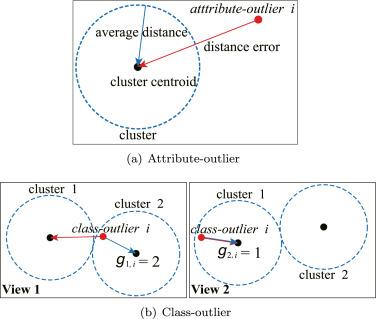

In [ ]:
# create an dict to store all k_means_colr values for all the images with flatten structure
k_means_cluster_colors = {i: [] for i in os.listdir(input_path)}
images = {i: [] for i in os.listdir(input_path)}

def k_means_cluster(classes):
    df = train[train['labels'] == classes]
    for idx in df.index:
        img_name = train.loc[idx,'image_id']
        img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
        img = imutils.resize(img,height=150)
        
        #normalize the given image
        norm_img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images[class_name].append(img_name) 
  
        #k-means chstering with cluster size of 5
        cluster_centers, distortion = kmeans(norm_img.reshape((-1,3)),5)

        #standard deviation for each color band
        std = np.expand_dims(img.reshape((-1,3)).std(axis=0),1) 
        
        if cluster_centers.shape[0]==5:
            k_means_cluster_colors[class_name].append((np.matmul(cluster_centers,std).T).astype(int)[0])
        else:
            k_means_cluster_colors[classes]=[]
            return k_means_cluster(classes)

for class_name in tqdm(train['labels'].unique()):
    k_means_cluster(class_name)

# **1.3 Z-Score**

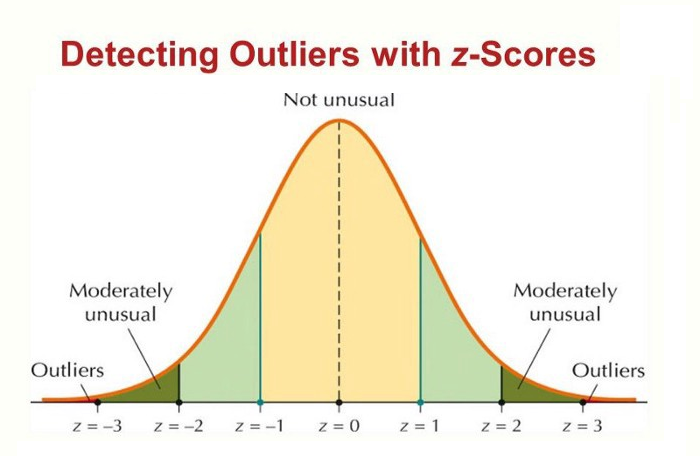

**$$Zscore=\frac{x-Mean}{Standart Deviation}$$**

In [ ]:
k_means_outliers = {i: [] for i in os.listdir(input_path)}

for idx,class_name in enumerate(k_means_cluster_colors):
    x = np.sum(k_means_cluster_colors[class_name],axis=1)
    z_score = zscore(x)
    k_means_outliers[class_name].append(list(np.where((z_score>3))[0]) + list(np.where((z_score<-3))[0]))

In [ ]:
rows = 3
cols = 3
fig =  make_subplots(rows=rows,cols=cols,subplot_titles=list(k_means_cluster_colors.keys()))
#fig =  make_subplots(rows=3,cols=3,subplot_titles=['Original Image', 'Normalized Image'])
colors = ['rgb({}, {}, {})'.format(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for iter in range(len(train['labels'].unique()))]
classes = 0

for row in range(rows):
    for col in range(cols):
        x = np.sum(k_means_cluster_colors[list(k_means_cluster_colors.keys())[classes]],axis=1)
        z_score = zscore(x)
        #fig=go.Figure()
        fig.add_trace(go.Histogram(x=z_score, marker_color=colors[classes]), row+1, col+1)
        classes+=1
    
fig.update_layout(height=600, width=800, title_text="Z-Score")
fig.show()

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Displaying outliers in the data</strong></p>

In [ ]:
imgs = []
for class_name in k_means_outliers:
    for idx in k_means_outliers[class_name][0]:
        imgs.append(images[class_name][idx])
        
gridimg = []        
for idx,img_name in enumerate(np.random.choice(imgs,8,replace=False)):
    np_image = mpimg.imread(img_name)
    gridimg.append(np_image)

fig = plt.figure(figsize=(25, 25))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 label_mode="1")

for ax, im in zip(grid, gridimg):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')

plt.show()

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Now let's delete them</strong></p>

In [ ]:
for images in imgs:
    os.remove(images)
    train = train.drop(train[train['image_id']==images].index)

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>After another deletion, let's check how the table has changed</strong></p>

In [ ]:
train

**To find out more:** https://www.kaggle.com/ramjib/cassava-leaf-disease-eda-and-outliers

 **Shuffle Data**


In [ ]:
import numpy as np
from sklearn.utils import shuffle

In [ ]:
X_shuffle, y_shuffle = shuffle(X, y, random_state=0)

In [ ]:
len(X_shuffle)

In [ ]:
len(y_shuffle)

In [ ]:
print(X_shuffle.shape)
print(y_shuffle.shape)


In [ ]:
split_index = int(len(X_shuffle) * 0.7)  
X_train, X_test = np.split(X_shuffle, [split_index])

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train, y_test = np.split(y_shuffle, [split_index])
print(y_train.shape)
print(y_test.shape)

**Logistic Regression**


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression().fit(X_train, y_train)

**Accuracy**


In [ ]:
clf.score(X_test, y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

# **2. Data preparation**

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>This function will help us save the training process in a separate file, which we can download after training in the working folder</strong></p>

In [ ]:
def init_logger(log_file='./'+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [ ]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Own dataset for loading data, nothing out of the ordinary</strong></p>

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['labels'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['labels'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}".format(self.df.loc[index]['image_id']))
        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.output_label == True:
            return img, target
        else:
            return img

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>For augmentation, I use my favorite library Albumentations. Also, the augmentations are divided into two parts, since we need to change the training part a lot, and the validation and test parts only slightly</strong></p>

In [ ]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)

    elif data == 'val':
        return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>This is what fish with different classes look like</strong></p>

In [ ]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  
example = all_data

rand_samples = [] 
for _ in range(25): 
#     rand_samples.append([random.sample([os.path.join(input_path+'/'+str(classes), str(filename)) for filename in os.listdir(input_path)], 1), classes]) 
    sample = random.sample(list(train['image_id']), 1)
    rand_samples.append([sample, train[train['image_id']==sample[0]]['labels'].values[0]])
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Here I have encoded the target values of the objects into numbers</strong></p>

In [ ]:
le = LabelEncoder()
sets = {'train':train, 'test':test}
for x in ['train', 'test']:
    sets[x]['labels'] = le.fit_transform(sets[x].labels.values)

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>This function gets the indexes for the pandas table and forms datasets from the corresponding objects. Then it wraps datasets in dataloaders depending on which accelerator you choose. It also gives out the length of datasets, that is, the number of objects in it in order to then calculate the accuracy and loss</strong></p>

In [ ]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='./Fish_Dataset'):

    train_ = df.reset_index().loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.reset_index().loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CustomDataset(train_, data_root, transforms=get_transforms(data='train'), output_label=True, one_hot_label=False)
    valid_ds = CustomDataset(valid_, data_root, transforms=get_transforms(data='val'), output_label=True)
    
    if CFG['accelerator']=='TPU':
        
        train_sampler = torch.utils.data.distributed.DistributedSampler(
            train_ds,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True
    )

        valid_sampler = torch.utils.data.distributed.DistributedSampler(
            valid_ds,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True
    )
    
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=CFG['train_bs'],
            pin_memory=True,
            drop_last=False,
            sampler=train_sampler,
            num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            sampler=valid_sampler,
            pin_memory=True,
    )
        
    if CFG['accelerator']=='GPU':
        
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=CFG['train_bs'],
            pin_memory=True,
            drop_last=False,
            shuffle=True,        
            num_workers=CFG['num_workers']
    )
        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=True
    )
    
    
    return train_loader, val_loader, len(train_ds), len(valid_ds)

# **3.  Training**

In [ ]:
from torch import autograd

def train_one_epoch(loader, epoch, model, optimizer, criterion, gradient_clipping=False):
   
   LOGGER.info('--------------------------------------------------------------')
   LOGGER.info('Epoch: {}/{}'.format(epoch+1, CFG['epochs']))
    
   model.train()

   running_loss = 0.
   running_corrects = 0.
    
   pbar = tqdm(enumerate(loader), total=len(loader))
   for step, (imgs, targets) in pbar:
        
      imgs, targets = imgs.to(device).float(), targets.to(device).long()
      if CFG['accelerator']=='GPU':
        with autocast():
            output = model(imgs)
            loss = criterion(output, targets)
            loss = loss / CFG['accum_iter']
        scaler.scale(loss).backward()
            
            
      if CFG['accelerator']=='TPU':
        output = model(imgs)
        gc.collect()
        loss = criterion(output, targets)
        loss = loss / CFG['accum_iter']
        loss.backward()
      
      if gradient_clipping:
        timm.utils.agc.adaptive_clip_grad(model.parameters(), clip_factor=CFG['grad_clip'], eps=1e-3, norm_type=2.0)
        
      _, pred = output.max(dim=1)
      running_corrects += torch.sum(pred == targets.data)
      running_loss += loss.item()*imgs.size(0)
    
      if loss.item()==float("NaN"):
            xm.master_print('0'*50)
            break
            
      description = f'train | epoch {epoch+1} | current loss: {loss.item()*imgs.size(0):.4f}'
      pbar.set_description(description)
    
      if ((step + 1) % CFG['accum_iter'] == 0) or ((step + 1) == len(loader)):
            
            if CFG['accelerator']=='GPU':
                scaler.step(optimizer)
                scaler.update()
                
            if CFG['accelerator']=='TPU':
                xm.optimizer_step(optimizer)
                
            optimizer.zero_grad()
   return running_corrects, running_loss

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Function for validation one epoch. I also want to draw your attention to gc.collect(). The point is that during training, memory problems can occur and everything will stop, so use this method to force the system to try to free the maximum amount of available memory</strong></p>

In [ ]:
def valid_one_epoch(loader,epoch, model, device, criterion):
    model.eval()
    
    running_loss = 0.
    running_corrects = 0.
    
    pbar = tqdm(enumerate(loader), total=len(loader))
    for step, (imgs, targets) in pbar:
       imgs, targets = imgs.to(device).float(), targets.to(device).long()
       with torch.no_grad():
             output = model(imgs)
             gc.collect()
             _, pred = output.max(dim=1)
             loss = criterion(output, targets)
       running_corrects += torch.sum(pred == targets.data)
       running_loss += loss.item()*imgs.size(0)
       gc.collect()
    
       description = f'val | epoch {epoch+1} | current loss: {loss.item()*imgs.size(0):.4f}'
       pbar.set_description(description)
                
    return running_corrects, running_loss

In [ ]:
def fit(seed, epochs, model, freeze, device, fold, train_loader, val_loader, criterion, gradient_clipping=False):
  
  if CFG['accelerator']=='TPU':
          LOGGER.info('Creating a model {}...'.format(seed))
          #device = xm.xla_device()
          WRAPPED_MODEL = xmp.MpModelWrapper(model)
          model = WRAPPED_MODEL.to(device)
          #model.to(device)
          if freeze==True:
            if seed==1:
              optimizer = torch.optim.Adam(model.head.parameters(), lr=CFG['lr']* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
            if seed==2 or seed==3:
              optimizer = torch.optim.Adam(model.fc.parameters(), lr=CFG['lr']* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
            if seed==4 or seed==0:
              optimizer = torch.optim.Adam(model.classifier.parameters(), lr=CFG['lr']* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
          if freeze==False:
            optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr']* xm.xrt_world_size(), betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
        
  if CFG['accelerator'] == 'GPU':
    LOGGER.info('Creating a model...')
    model.to(device)
    if freeze==True:
        if seed==1:
            optimizer = torch.optim.Adam(model.head.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
        if seed==2 or seed==3:
            optimizer = torch.optim.Adam(model.fc.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
        if seed==4 or seed==0:
            optimizer = torch.optim.Adam(model.classifier.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])           
    if freeze==False:
       optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])
    
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  if CFG['accelerator']=='TPU':
     if freeze==True:
                                         
        for fase in ['CLASSIFIER TRAINING', 'ALL NET TRAINING']:
                                         
            if fase=='ALL NET TRAINING':             
               model.load_state_dict(best_model)
               for param in model.parameters():
                   param.requires_grad=True
               optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr']* xm.xrt_world_size()/10, betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])  
               scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)     
                                         
            for epoch in range(epochs):
                                         
                #train
                para_loader = pl.ParallelLoader(train_loader, [device])
                running_corrects, running_loss = train_one_epoch(para_loader.per_device_loader(device), epoch, model, optimizer, criterion, gradient_clipping)
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects/ train_len
                all_accuracies['fold_{}'.format(fold+1)][0].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][0].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('train', epoch_loss, epoch_acc))
                del para_loader
                gc.collect()
                
                #val
                para_loader = pl.ParallelLoader(val_loader, [device])
                running_corrects, running_loss = valid_one_epoch(para_loader.per_device_loader(device), epoch, model, device, criterion)
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects/ val_len
                all_accuracies['fold_{}'.format(fold+1)][1].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][1].append(epoch_loss)
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('val', epoch_loss, epoch_acc))
                del para_loader
                gc.collect()
                   
                #epoch end
                LOGGER.info('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                LOGGER.info('=='*31)
                if epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())
                scheduler.step()
      
            time_elapsed = time.time() - since
            LOGGER.info('{} TIME {}m {}s'.format(fase, time_elapsed//60, time_elapsed%60))
            LOGGER.info('=='*31)
                                         
     if freeze==False:
        for epoch in range(epochs):
                                         
                #train
                para_loader = pl.ParallelLoader(train_loader, [device])
                running_corrects, running_loss = train_one_epoch(para_loader.per_device_loader(device), epoch, model, optimizer, criterion, gradient_clipping)
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects/ train_len
                all_accuracies['fold_{}'.format(fold+1)][0].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][0].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('train', epoch_loss, epoch_acc))
                del para_loader
                gc.collect()
                
                
                #val
                para_loader = pl.ParallelLoader(val_loader, [device])
                running_corrects, running_loss = valid_one_epoch(para_loader.per_device_loader(device), epoch, model, device, criterion)
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects/ val_len
                all_accuracies['fold_{}'.format(fold+1)][1].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][1].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('val', epoch_loss, epoch_acc))
                del para_loader
                gc.collect()
    
                #epoch end
                LOGGER.info('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                LOGGER.info('=='*31)
                if epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())
                scheduler.step()
      
        time_elapsed = time.time() - since
        LOGGER.info('FOLD_{} TRAINING TIME {}m {}s'.format(fold+1, time_elapsed//60, time_elapsed%60))
        LOGGER.info('=='*31) 
                                         
                                         
  if CFG['accelerator']=='GPU':
     if freeze==True:
                                         
        for fase in ['CLASSIFIER TRAINING', 'ALL NET TRAINING']:
                                         
            if fase=='ALL NET TRAINING':             
               model.load_state_dict(best_model)
               for param in model.parameters():
                   param.requires_grad=True
               optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr']/10, betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG['weight_decay'])  
               scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)     
                                         
            for epoch in range(CFG['epochs']):
                                         
                #train                           
                running_corrects, running_loss = train_one_epoch(train_loader, epoch, model, optimizer, criterion, gradient_clipping)
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects/ train_len
                all_accuracies['fold_{}'.format(fold+1)][0].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][0].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('train', epoch_loss, epoch_acc))
                
                #val
                running_corrects, running_loss = valid_one_epoch(val_loader, epoch, model, device, criterion)
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects/ val_len
                all_accuracies['fold_{}'.format(fold+1)][1].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][1].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('val', epoch_loss, epoch_acc))
                
                #epoch end
                LOGGER.info('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                LOGGER.info('=='*31)
                if epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())
                scheduler.step()
      
            time_elapsed = time.time() - since
            LOGGER.info('{} TIME {}m {}s'.format(fase, time_elapsed//60, time_elapsed%60))
            LOGGER.info('=='*31)
                                         
     if freeze == False :
        for epoch in range(epochs):
                
                #train                           
                running_corrects, running_loss = train_one_epoch(train_loader, epoch, model, optimizer, criterion, gradient_clipping)
                epoch_loss = running_loss / train_len
                epoch_acc = running_corrects/ train_len
                all_accuracies['fold_{}'.format(fold+1)][0].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][0].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('train', epoch_loss, epoch_acc))
                
                #val                             
                running_corrects, running_loss = valid_one_epoch(val_loader, epoch, model, device, criterion)
                epoch_loss = running_loss / val_len
                epoch_acc = running_corrects/ val_len
                all_accuracies['fold_{}'.format(fold+1)][1].append(epoch_acc) 
                all_losses['fold_{}'.format(fold+1)][1].append(epoch_loss) 
                LOGGER.info('{} - loss:{}, accuracy:{}'.format('val', epoch_loss, epoch_acc))
                
                #epoch end
                LOGGER.info('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
                LOGGER.info('=='*31)
                if epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())
                scheduler.step()
      
        time_elapsed = time.time() - since
        LOGGER.info('FOLD_{} TRAINING TIME {}m {}s'.format(fold+1, time_elapsed//60, time_elapsed%60))
        LOGGER.info('=='*31) 
                                         
  if CFG['accelerator']=='TPU':
     xm.save(best_model,'{}_fold_{}.pth'.format(CFG['model_arch'], fold+1))
  if CFG['accelerator']=='GPU':
     torch.save(best_model,'{}_fold_{}.pth'.format(CFG['model_arch'], fold+1))
  
  LOGGER.info('Prediction Saved! \n')

In [ ]:
CFG

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Everything is very simple here. We just split the data into folds and train (cross-validation). But since my task is simply to show how everything works, we will be validated on one fold. The weights from this model were ported from https://cv.gluon.ai/model_zoo/classification.html</strong></p>

In [ ]:
if __name__ == '__main__':
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.labels.values)
    
    fold_best_acc = []
    
    all_losses = {f'fold_{x+1}':[[],[]] for x in range(CFG['fold_num'])}
    all_accuracies = {f'fold_{x+1}':[[],[]] for x in range(CFG['fold_num'])}
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        
        #we'll train fold 0 first
        if fold > 0:
            break 
            
        LOGGER.info('\n\n')
        LOGGER.info(f'========== fold: {fold+1} training ==========')
        LOGGER.info('Accelerator: {}'.format(CFG['accelerator']))
        LOGGER.info(f'Device: {device}')
            
        train_loader, val_loader, train_len, val_len = prepare_dataloader(train, trn_idx, val_idx, data_root='./Fish_Dataset')
        model = timm.create_model(CFG['model_arch'], pretrained=True, num_classes=CFG['num_classes'])
        if CFG['accelerator']=='GPU':
            model = nn.DataParallel(model).to(device)
        scaler = GradScaler()
        criterion = nn.CrossEntropyLoss().to(device)
        #criterion = TaylorCrossEntropyLossV1().to(device)
        fit(seed=1, epochs = CFG['epochs'], model=model, freeze=False, device=device, fold=fold, train_loader=train_loader, val_loader=val_loader, criterion=criterion, gradient_clipping=False)

        LOGGER.info(f'========== fold: {fold+1} result ==========')
        LOGGER.info('Score: {}'.format(max(all_accuracies['fold_{}'.format(fold+1)][1])))
        fold_best_acc.append(max(all_accuracies['fold_{}'.format(fold+1)][1]))   
        
        del model, train_loader, val_loader#, scaler
        torch.cuda.empty_cache()
    # CV result
    LOGGER.info(f"========== CV ==========")
    LOGGER.info(f'Score: {max(fold_best_acc)}')

# **4. Test**

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Before that we saved the model and now we are downloading the best one</strong></p>

In [ ]:
model = timm.create_model('gluon_resnet50_v1b', pretrained=False, num_classes=CFG['num_classes'])
if CFG['accelerator']=='GPU':
    model = nn.DataParallel(model).to(device)
state = torch.load('./gluon_resnet50_v1b_fold_1.pth')
model.load_state_dict(state);
model.to(device);

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Let's see what the test data looks like</strong></p>

In [ ]:
test

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>We load the data into the dataset and wrap it in the dataloader</strong></p>

In [ ]:
#test.reset_index()
test_ds= CustomDataset(test, './Fish_Dataset', transforms=get_transforms(data='val'), output_label=True)
test_loader = torch.utils.data.DataLoader(
            test_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=True)
test_len = len(test_ds)

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>Function for predicting a test sample</strong></p>

In [ ]:
def test_func(loader, model, test_len):
        with torch.no_grad():
            model.eval()
            running_corrects = 0.
            pbar = tqdm(enumerate(loader), total=len(loader))
            for step, (imgs, targets) in pbar:
                imgs, targets = imgs.to(device).float(), targets.to(device).long()
                output = model(imgs)
                _, pred = output.max(dim=1)
                running_corrects += torch.sum(pred == targets.data)
                
            acc = running_corrects / test_len    
            return acc

<p style = "color : #28AFEA; font-size : 15px; font-family : 'Comic Sans MS';"><strong>We start and get the accuracy at the output</strong></p>

In [ ]:
accuracy = test_func(test_loader, model, test_len).item()
accuracy